In [11]:
import csv
import pandas
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import collections
import re
import ast
import numpy as np
from pathlib import Path, PureWindowsPath



In [12]:
def IntegralIncrease1(nums: list) ->float:
    #method 1:
    #return the sum of all local max-local min
    #start from beginning point: r5 substate
    
    loc_min, loc_max=nums[0], nums[0]
    res=0
    for i in range(1, len(nums)):
        if nums[i] > nums[i-1]:
            loc_max = nums[i]
        elif nums[i] < nums[i-1]:
            res += loc_max - loc_min
            loc_min=nums[i]
            loc_max=nums[i]
    res += loc_max-loc_min
    return res

def IntegralIncrease2(nums: list)->float:
    #method2:
    #return the sum of all local max-local min
    #start from second last one point: r1 substate
    
    loc_min, loc_max=nums[-2], nums[-2]
    res=0
    for i in range(-1, len(nums)-1):
        if nums[i] > nums[i-1]:
            loc_max = nums[i]
        elif nums[i] < nums[i-1]:
            res += loc_max - loc_min
            loc_min=nums[i]
            loc_max=nums[i]
    
    res += loc_max-loc_min
    return res



def crgstringtolist(crg_s: str)->list:
    #fuction to read crg_seq from string into crg set
    #return a list of charges
    n=len(crg_s)
    i=0
    res=[]
    while i < n:
        if crg_s[i]=='1':
            res.append(1)
            i +=1
        elif crg_s[i]=='0':
            res.append(0)
            i +=1
        else:
            res.append(int(crg_s[i:i+2]))
            i +=2
    return res

def readMsE2df(dicts: dict, substate: str): 
    #read all_ms_E format file, and output structure and energy informations
    #return a dataframe
    substate=str(substate)
    df_e1=[]
    columns_e1=['state_snap', 'E(-3)_min_'+substate, 'E(-4)_min_'+substate, 'ms(-3)_minE_'+substate, 'ms(-4)_minE_'+substate,\
                'E_self(-3)_'+substate,'E_self(-4)_'+substate, 'E_pw(-3)_'+substate,'E_pw(-4)_'+substate,\
                'E_mfe(-3)_'+substate,'E_mfe(-4)_'+substate,\
                r'$\bigtriangleup$E_'+substate,\
                r'$\bigtriangleup$E_self_'+substate,r'$\bigtriangleup$E_pw_'+substate, r'$\bigtriangleup$E_mfe_'+substate]

    ##read data into df_e1
    for struc, dataframe in dicts.items():
        tmp=dataframe.iloc[:7]
        data=[struc]
        data.append(tmp['Min_E(Kcal)'][2])
        data.append(tmp['Min_E(Kcal)'][1])
        data.append(crgstringtolist(tmp['Crg_seq'][2]))
        data.append(crgstringtolist(tmp['Crg_seq'][1]))
        data.extend([tmp['E_self(Kcal)'][2],tmp['E_self(Kcal)'][1], tmp['E_pw(Kcal)'][2],tmp['E_pw(Kcal)'][1],\
                     tmp['E_mfe(Kcal)'][2],tmp['E_mfe(Kcal)'][1]])
        data.append(tmp['Min_E(Kcal)'][1]-tmp['Min_E(Kcal)'][2])
        data.append(tmp['E_self(Kcal)'][1]-tmp['E_self(Kcal)'][2])
        data.append(tmp['E_pw(Kcal)'][1]-tmp['E_pw(Kcal)'][2])
        data.append((tmp['E_mfe(Kcal)'][1]-tmp['E_mfe(Kcal)'][2])*2)
        df_e1.append(data)
    
    return pandas.DataFrame(df_e1, columns = columns_e1)    

def readMsOcc2df(dicts: dict, substate: str): 
    #read ms_occ format file, and output structure and energy informations
    #return a dataframe
    substate=str(substate)
    df_e1=[]
    columns_e1=['state_snap', 'Tot_crg', 'E(Kcal)', 'Occ',\
                'ms_str','ms', 'Conf_Names']

    
    ##read data into df_e1
    for struc, dataframe in dicts.items():
        for i in range(dataframe.shape[0]):
            data=[struc]
            data.append(dataframe.iloc[i]['Tot_crg'])
            data.append(dataframe.iloc[i]['E(Kcal)'])
            data.append(dataframe.iloc[i]['Occ'])
            data.append(dataframe.iloc[i]['Crg_seq'])
            data.append(crgstringtolist(dataframe.iloc[i]['Crg_seq']))
            data.append(dataframe.iloc[i]['Conf_Names'])
            
            df_e1.append(data)
    
    return pandas.DataFrame(df_e1, columns = columns_e1)   

def readMsCrgseq2df(dicts: dict, substate: str): 
    #read ms_occ format file, and output structure and energy informations
    #return a dataframe
    substate=str(substate)
    df_e1=[]
    columns_e1=['state_snap', 'Tot_crg', 'ms_str','ms', '[Enes(Kcal), Occ]']

    
    ##read data into df_e1
    for struc, dataframe in dicts.items():
        
        for i in range(dataframe.shape[0]):
            data=[struc]
            data.append(dataframe.iloc[i]['Tot_crg'])
            data.append(dataframe.iloc[i]['Crg_seq'])
            data.append(crgstringtolist(dataframe.iloc[i]['Crg_seq']))
            #print(struc, i)
            Enes=ast.literal_eval(dataframe.iloc[i]['[E(Kcal), Occ]'])
            #print(len(Enes))
            data.append(Enes)
            
            df_e1.append(data)
    
    return pandas.DataFrame(df_e1, columns = columns_e1)   


def color_struc(s, color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    #copy df to new - original data are not changed
    df = s.copy()
    #set by condition
    df.loc[:,:] = 'background-color: blue '
    for key in color_map:
        
        mask = s[column] == key
        #print(mask)
        df.loc[mask, :] = 'background-color: {}'.format(color_map.get(key))
    #print(df)
    return df    


def readClusteringFile(file, dataframe):
    #read clustering information from filepath and append the information into dataframe
    
    columns=['traj/xray', 'time_point','cluster_size']
    with open(file, 'r') as f:
        next(f)
        data=[]
        for line in f:
            line=line.strip()
            if line:
                line= re.split(':|,|\(|\)' , line)
                
                if len(line)==1: continue
                if len(line)==2:  # read the traj/xry information
                    struc=line[0]
                    continue
                time_point=int(line[4])
                cluster_size=int(line[2])
                data.append([struc, str(time_point), cluster_size])
    
    df=pandas.DataFrame(data, columns = columns)
    #print(df)
    return pandas.merge(dataframe, df, how='outer', on =['traj/xray','time_point'])

def colormaps(color_map, column):
    '''
    color each row by column value based on colormap .
    '''
    n=len(column)
    ans=[''] * n
    for i, x in enumerate(column):
        ans[i]=color_map.get(x,'blue')
        #print(x, ans[i])
    return ans
    



def plotEneMap(x:list, y:list, z:list, *args, **kwargs)->None:
    '''
    x: x axis
    y: y axis
    z: z axis to color each grid
    filename: filename to save the figure
    '''
    filename=kwargs.get('filename', None)
    
    
    plt.figure(figsize=(15,15))

    #plt.pcolormesh([x,y],z)

    #plt.imshow(z+10, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), cmap='RdBu')
    Z=np.array(z)
    plt.scatter(x, y, c=Z,norm=colors.LogNorm(),  cmap='hot')
    x_cat=[0.5,24.5, 87.5, 93.5]
    y_cat=[0.5, 6.5, 21.5, 41.5, 56.5, 62.5]
    for i in -np.array(x_cat)+107:
        if min(x) < i< max(x):
            plt.axvline(x=i,color='k',linestyle='--', lw=0.7)
    for i in y_cat:
        if min(y) < i< max(y):
            plt.axhline(y=i,color='k',linestyle='--', lw=0.7)

    plt.colorbar()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


from matplotlib.ticker import MaxNLocator
def plotEneMap2(x:list, y:list, z:list, *args, **kwargs)->None:
    '''
    x: x axis
    y: y axis
    z: z axis to color each grid
    filename: filename to save the figure
    '''
    filename=kwargs.get('filename', None)
    x_cat=kwargs.get('x_cat', [0,1,25, 88, 94, 107])
    x_cat_ticklabels=kwargs.get('x_cat_ticklabels', ['1\'','1','2', '3', '4'])
    y_cat=kwargs.get('y_cat',[0,1, 7, 22, 42, 57, 63])
    y_cat_ticklabels=kwargs.get('y_cat_ticklabels', ['-5.0','-4.0','-3.0', '-2.0', '-1.0', '0.0', '1.0'])
    
    x_cat_minor, y_cat_minor=[],[]
    
    #reverse the category
    x_cat=-np.array(x_cat)+107
    for i in range(1,len(x_cat)):
        x_cat_minor.append((x_cat[i]+x_cat[i-1])/2)
    
    for i in range(1,len(y_cat)):
        y_cat_minor.append((y_cat[i]+y_cat[i-1])/2)
    #x_cat_minor=[0.5,13, 56.5, 91, 100.5]
    #x_cat_ticklabels=['1\'','1','2', '3', '4']
    #y_cat_minor=[0.5, 4, 14.5, 32, 49.5, 60]
    #y_cat_ticklabels=['-5.0','-4.0','-3.0', '-2.0', '-1.0', '0.0', '1.0']
    
    X, Y,Z= list(zip(*sorted(zip(x, y, z))))
    
    X=np.reshape(X,(108, len(X)//108)).T
    Y=np.reshape(Y,(108, len(Y)//108)).T
    Z=np.reshape(Z,(108, len(Z)//108)).T
    #print(Y)
    
    fig= plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    ax3 = ax1.twinx()

    fig1=ax1.pcolormesh(X,Y,Z,norm=colors.LogNorm(), cmap='hot')
    #fig1=ax1.pcolor(X,Y,Z,norm=colors.LogNorm(), cmap='hot')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    
    

    
    xstart, xend=len(x_cat), 0
    ystart, yend=len(y_cat),0
    for i, cat in enumerate(x_cat[1:]):
        if min(x) < cat < max(x):
            xstart, xend=min(i, xstart), max(xend,i)      
            ax1.axvline(x=cat,color='k', linestyle='--', lw=0.7)
            

    for i,cat in enumerate(y_cat[1:]):
        if min(y) < cat < max(y):
            ystart, yend=min(i, ystart), max(yend,i)    
            ax1.axhline(y=cat,color='k', linestyle='--', lw=0.7)
     
    
    ax1.set_xlabel('Structrue')
    ax1.set_ylabel('Microstate')
    
    #print(x_cat[xstart: xend+2],y_cat[ystart:yend+2] )
    ax2.tick_params(axis="x", direction="in", length=0, width=2)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(x_cat_minor[xstart: xend+2])
    ax2.set_xticklabels(x_cat_ticklabels[xstart: xend+2])
    ax2.set_xlabel('Category')
    
    
    ax3.tick_params(axis="y", direction="in", length=0, width=2)
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_yticks(y_cat_minor[ystart: yend+2])
    ax3.set_yticklabels(y_cat_ticklabels[ystart:yend+2])
    ax3.set_ylabel('Ionization state')
    

    
    cbar_ax = fig.add_axes([1., 0.1, 0.03, 0.8])
    fig.colorbar(fig1, cax=cbar_ax)
    #fig.colorbar(fig1, orientation="horizontal", pad=0.2)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
 
        
def resetEenBase(x:list,y:list,z:list)->None:
    '''
    x: x axis
    y: y axis
    z: z axis to color each grid
    for the same x, the minE will be the Energy base.
    '''
    x_Ebase={}
    for i in range(len(x)):
        x_Ebase[x[i]]=min(x_Ebase.get(x[i], z[i]), z[i])
    
    for i in range(len(x)):
        z[i] = z[i]-x_Ebase[x[i]]
        
        
    
        
        
def exportxyz(df):
    '''
    Numbering structure by categories(sort by average ionization state of PLS)
    '''
    x=[]
    y=[]
    z=[]
    strucs={}
    struc_index=0
    crgseqs={}
    crgseq_index=0
    
    res=['ASP287', 'ASP372', 'HIS376', 'GLUB126', 'PRAa3','PRDa3' ]
    
    
    for i,crg in enumerate(zip(*df['ms'])):
        df[res[i]]=crg
       
    #print(df)
    
    ##numbering strucs
    struc_category= [['d372ph376p_288_frame'], 
                     ['d372ph376p_141_frame', '3eh4', 'd372ph376p_404_frame', 'd372ph376p_55_frame', 
                      'd372ph376p_456_frame', 'd372ph376p_432_frame', 'd372ph376p_411_frame', 'd372ph376p_243_frame', 
                      'd372ph376p_166_frame', 'd372ph376p_68_frame', 'd372ph376p_368_frame', 'd372ph376p_255_frame',
                      '3s8f', '3s3b', '1ehk', '1xme', '4gp4', '4gp5', '3eh3', '3eh5', '3s3d', '3s3a', 'd372ph376p_468_frame', '3s3c'], 
                     ['p3_435_frame', 'p3_190_frame', 'd372p_18_frame','p3_218_frame', 'd372p_54_frame', 'p3_467_frame',
                      'd372p_151_frame', 'p3_297_frame', 'd372p_253_frame', 'd372p_287_frame', 'p3_186_frame',
                      'p3_98_frame', 'd372p_365_frame', 'd372p_179_frame', 'd372p_152_frame', 'd372p_207_frame', 
                      'p3_443_frame', 'p2_139_frame', 'p3_419_frame', 'p2_145_frame', 'd372p_167_frame', 
                      'd372p_370_frame', 'd372p_318_frame', 'd372p_230_frame', 'd372p_289_frame', 'p3_494_frame',
                      'p3_226_frame', 'p3_132_frame', 'p2_148_frame', 'p2_359_frame', 'p2_25_frame', 'd372p_491_frame',
                      'p4_219_frame', 'p2_126_frame', 'p4_2_frame', 'p2_461_frame', 'p2_277_frame', 'p2_432_frame', 
                      'p2_125_frame', 'p4_25_frame', 'p2_185_frame', 'p4_153_frame', 'p2_361_frame', 'p2_86_frame', 
                      'p2_249_frame', 'p4_135_frame', 'p4_129_frame', 'p1_6_frame', 'p1_58_frame', 'p4_32_frame', 
                      'p2_364_frame', 'p2_262_frame', 'p1_232_frame', 'p2_194_frame', 'p4_236_frame', 'p1_311_frame',
                      'p2_402_frame', 'p4_64_frame', 'p1_294_frame', 'p2_55_frame', 'p2_423_frame', 'p4_50_frame', 
                      'p1_84_frame'], ['p2_465_frame', 'p2_39_frame', 'p2_76_frame', 'p2_468_frame', 'p4_45_frame', 'p1_35_frame'], 
                     ['p4_131_frame', 'p1_39_frame', 'p4_209_frame', 'p4_168_frame','p1_215_frame', 'p1_228_frame',
                      'p4_113_frame', 'p1_188_frame', 'p1_170_frame', 'p1_425_frame', 'p1_270_frame', 'p1_477_frame',
                      'p1_379_frame', 'p1_428_frame']]
    
    
    
    for i in struc_category:
        for j in i:
            strucs[j]=struc_index
            struc_index +=1
            
    #print(strucs)       
            
    df.sort_values(by=['state_snap','Tot_crg']+res,inplace=True)
    #print(df)
    for index, row in df.iterrows():
        struc=row['state_snap']
        crgseq=row['ms_str']
        if struc not in strucs:
            strucs[struc]=struc_index
            struc_index +=1
        if crgseq not in crgseqs:
            crgseqs[crgseq]=[crgseq_index, row['Tot_crg']]
            crgseq_index +=1
        
        #print(struc,strucs)
        x.append(strucs[struc])
        y.append(crgseqs[crgseq][0])
        z.append(row['[Enes(Kcal), Occ]'][0][0])
    return x,y,z, strucs, crgseqs


def exportxyz2(df):
    '''
    Numbering structure by trajectories/xrays
    '''
    x, y,z=[],[],[]
    strucs={}
    struc_index=0
    crgseqs={}
    crgseq_index=0
    
    res=['ASP287', 'ASP372', 'HIS376', 'GLUB126', 'PRAa3','PRDa3' ]
    
    
    for i,crg in enumerate(zip(*df['ms'])):
        df[res[i]]=crg
       
    #print(df)
    
    ##numbering strucs
    struc_category= [['d372ph376p_288_frame'], 
                     ['d372ph376p_141_frame', '3eh4', 'd372ph376p_404_frame', 'd372ph376p_55_frame', 
                      'd372ph376p_456_frame', 'd372ph376p_432_frame', 'd372ph376p_411_frame', 'd372ph376p_243_frame', 
                      'd372ph376p_166_frame', 'd372ph376p_68_frame', 'd372ph376p_368_frame', 'd372ph376p_255_frame',
                      '3s8f', '3s3b', '1ehk', '1xme', '4gp4', '4gp5', '3eh3', '3eh5', '3s3d', '3s3a', 'd372ph376p_468_frame', '3s3c'], 
                     ['p3_435_frame', 'p3_190_frame', 'd372p_18_frame','p3_218_frame', 'd372p_54_frame', 'p3_467_frame',
                      'd372p_151_frame', 'p3_297_frame', 'd372p_253_frame', 'd372p_287_frame', 'p3_186_frame',
                      'p3_98_frame', 'd372p_365_frame', 'd372p_179_frame', 'd372p_152_frame', 'd372p_207_frame', 
                      'p3_443_frame', 'p2_139_frame', 'p3_419_frame', 'p2_145_frame', 'd372p_167_frame', 
                      'd372p_370_frame', 'd372p_318_frame', 'd372p_230_frame', 'd372p_289_frame', 'p3_494_frame',
                      'p3_226_frame', 'p3_132_frame', 'p2_148_frame', 'p2_359_frame', 'p2_25_frame', 'd372p_491_frame',
                      'p4_219_frame', 'p2_126_frame', 'p4_2_frame', 'p2_461_frame', 'p2_277_frame', 'p2_432_frame', 
                      'p2_125_frame', 'p4_25_frame', 'p2_185_frame', 'p4_153_frame', 'p2_361_frame', 'p2_86_frame', 
                      'p2_249_frame', 'p4_135_frame', 'p4_129_frame', 'p1_6_frame', 'p1_58_frame', 'p4_32_frame', 
                      'p2_364_frame', 'p2_262_frame', 'p1_232_frame', 'p2_194_frame', 'p4_236_frame', 'p1_311_frame',
                      'p2_402_frame', 'p4_64_frame', 'p1_294_frame', 'p2_55_frame', 'p2_423_frame', 'p4_50_frame', 
                      'p1_84_frame'], ['p2_465_frame', 'p2_39_frame', 'p2_76_frame', 'p2_468_frame', 'p4_45_frame', 'p1_35_frame'], 
                     ['p4_131_frame', 'p1_39_frame', 'p4_209_frame', 'p4_168_frame','p1_215_frame', 'p1_228_frame',
                      'p4_113_frame', 'p1_188_frame', 'p1_170_frame', 'p1_425_frame', 'p1_270_frame', 'p1_477_frame',
                      'p1_379_frame', 'p1_428_frame']]
    
    
    struc_trajs=["d372ph376p_", "d372p_", "p3_", "p2_", "p4_", "p1_"]
    
    #numbering xray first
    for i in struc_category:
        for j in i:
            if all(s not in j for s in struc_trajs):
                strucs[j]=struc_index
                struc_index +=1
    for s in struc_trajs:
        for i in struc_category:
            for j in i:
                if s in j:
                    strucs[j]=struc_index
                    struc_index +=1
                    
            
    print(strucs)       
            
    df.sort_values(by=['state_snap','Tot_crg']+res,inplace=True)
    #print(df)
    for index, row in df.iterrows():
        struc=row['state_snap']
        crgseq=row['ms_str']
        if struc not in strucs:
            strucs[struc]=struc_index
            struc_index +=1
        if crgseq not in crgseqs:
            crgseqs[crgseq]=[crgseq_index, row['Tot_crg']]
            crgseq_index +=1
        
        #print(struc,strucs)
        x.append(strucs[struc])
        y.append(crgseqs[crgseq][0])
        z.append(row['[Enes(Kcal), Occ]'][0][0])
    return x,y,z, strucs, crgseqs

        
def limitxy(x,y,z, *args, **kwargs):
    xmin=kwargs.get('xmin',0)
    xmax=kwargs.get('xmax',len(x)-1)
    ymin=kwargs.get('ymin', 0)
    ymax=kwargs.get('ymax',41)
    
    
    newxyz=[]
    for i,j,k in zip(*[x,y,z]):
        if ymin<= j <= ymax and xmin<= i <= xmax:
            newxyz.append([i,j,k])
        
    return list(map(list, zip(*newxyz)))
            
    
 
    
    
        

# Import microstate energy for each charge sequence of PLS into dataframe: df_e1/df_f3

In [15]:
#import crystal and md at e1/f3 substate data files

filepath_cry_e1='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/ms_crgseq_e1.xlsx'
filepath_md_e1='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/ms_crgseq_e1.xlsx'
#f3 data files pathway
filepath_cry_f3='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/12Xry+initalMdSturcs/ms_crgseq_f3.xlsx'
filepath_md_f3='/Users/PC/Dropbox/cai/btype_cco/crg_data/quick_run_mdlip/clusteringMd96Strucs/clusteringByPLS/ms_crgseq_f3.xlsx'


#crystal structure name
cry_name= ["1ehk","1xme","4gp4","4gp5","3eh3","3eh5","3s3b","3s3d","3eh4","3s3a","3s3c","3s8f"]


file_cry_e1 = pandas.read_excel(filepath_cry_e1, sheetname=None, index_col=1)
file_md_e1 = pandas.read_excel(filepath_md_e1, sheetname=None, index_col=1)
file_cry_f3 = pandas.read_excel(filepath_cry_f3, sheetname=None, index_col=1)
file_md_f3 = pandas.read_excel(filepath_md_f3, sheetname=None, index_col=1)


file_cry_e1.update(file_md_e1)
file_e1=file_cry_e1   # store data for e1 substate

file_cry_f3.update(file_md_f3)
file_f3= file_cry_f3   # store data for f3 substate


# read min_e, e_self, e_pw, e_mfe
df_e1=readMsCrgseq2df(file_e1,'e1')
df_f3=readMsCrgseq2df(file_f3,'f3')


In [16]:
x1,y1,z1,x_label1, y_label1=exportxyz(df_e1)
x2,y2,z2, x_label2, y_label2=exportxyz(df_f3)

In [17]:
resetEenBase(x1,y1,z1)
resetEenBase(x2,y2,z2)

In [18]:
#crgseqs, [crgseq_index, 'Tot_crg']
print(sorted(y_label1.items(), key=lambda kv: kv[1][0]))

#struc:struc_index
print(x_label1)
if x_label1 != x_label2:
    print(False)

[('-1-10-1-1-1', [0, -5]), ('-1-10-1-10', [1, -4]), ('-1-10-10-1', [2, -4]), ('-1-100-1-1', [3, -4]), ('-1-11-1-1-1', [4, -4]), ('-100-1-1-1', [5, -4]), ('0-10-1-1-1', [6, -4]), ('-1-10-100', [7, -3]), ('-1-100-10', [8, -3]), ('-1-1000-1', [9, -3]), ('-1-11-1-10', [10, -3]), ('-1-11-10-1', [11, -3]), ('-1-110-1-1', [12, -3]), ('-100-1-10', [13, -3]), ('-100-10-1', [14, -3]), ('-1000-1-1', [15, -3]), ('-101-1-1-1', [16, -3]), ('0-10-1-10', [17, -3]), ('0-10-10-1', [18, -3]), ('0-100-1-1', [19, -3]), ('0-11-1-1-1', [20, -3]), ('000-1-1-1', [21, -3]), ('-1-10000', [22, -2]), ('-1-11-100', [23, -2]), ('-1-110-10', [24, -2]), ('-1-1100-1', [25, -2]), ('-100-100', [26, -2]), ('-1000-10', [27, -2]), ('-10000-1', [28, -2]), ('-101-1-10', [29, -2]), ('-101-10-1', [30, -2]), ('-1010-1-1', [31, -2]), ('0-10-100', [32, -2]), ('0-100-10', [33, -2]), ('0-1000-1', [34, -2]), ('0-11-1-10', [35, -2]), ('0-11-10-1', [36, -2]), ('0-110-1-1', [37, -2]), ('000-1-10', [38, -2]), ('000-10-1', [39, -2]), ('00

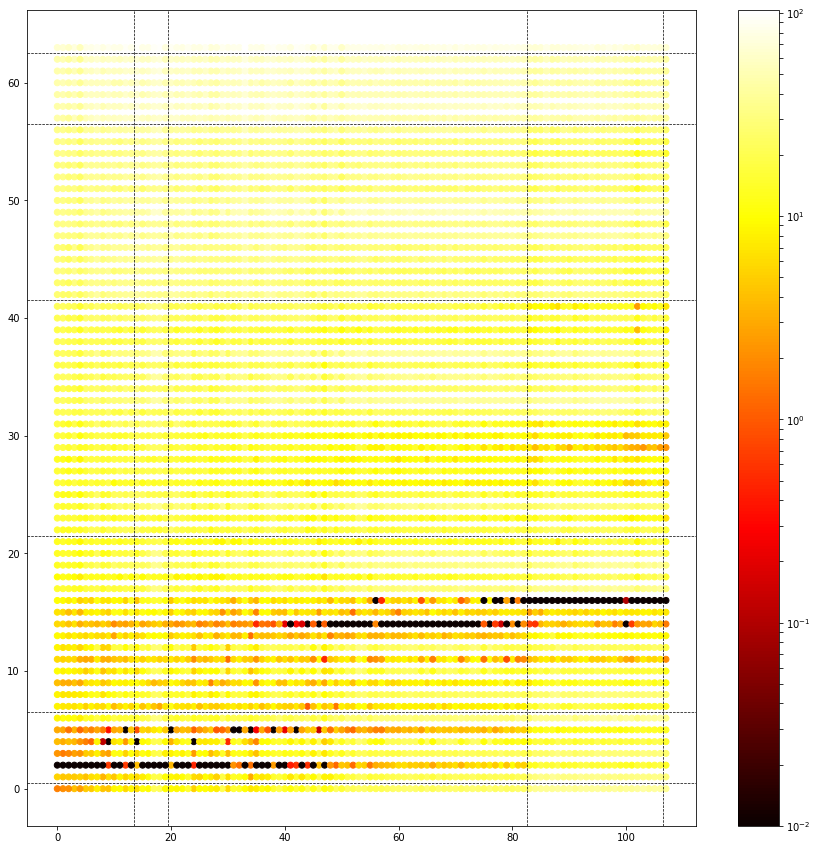

In [19]:
plotEneMap(-np.array(x1)+107,y1,np.array(z1)+10**-2)

C:\Users\PC\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


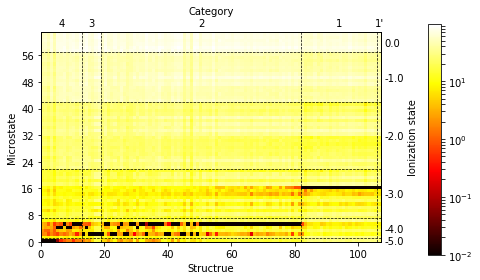

In [20]:
plotEneMap2(-np.array(x2)+107,y2,np.array(z2)+10**-2)

In [21]:
es_e1=[z for x,y,z in zip(x1,y1,z1) if y > 41]
es_f3=[z for x,y,z in zip(x2,y2,z2) if y > 41]
#print(es_e1)
print('min and max energy difference at E1 within the minimum all all structures: %f, %f'%(min(es_e1), max(es_e1))) 
print('min and max energy difference at F3 within the minimum all all structures: %f, %f'%(min(es_f3), max(es_f3))) 



min and max energy difference at E1 within the minimum all all structures: 10.980000, 102.978000
min and max energy difference at F3 within the minimum all all structures: 24.995000, 124.243000


In [22]:
es_e1=[z for x,y,z in zip(x1,y1,z1) if y==14 and x < 25]
es_f3=[z for x,y,z in zip(x2,y2,z2) if y==14 and x < 25]
#print(es_e1)
print('min and max energy difference at E1 of Category 1 at -4.0: %f, %f'%(min(es_e1), max(es_e1))) 
print('min and max energy difference at F3  of Category 1 at -4.0: %f, %f'%(min(es_f3), max(es_f3))) 


min and max energy difference at E1 of Category 1 at -4.0: 0.000000, 6.366000
min and max energy difference at F3  of Category 1 at -4.0: 2.460000, 8.021000


In [23]:
es_e1_14=[z for x,y,z in zip(x1,y1,z1) if y==14 and 88<=x<94 ]
es_e1_2=[z for x,y,z in zip(x1,y1,z1) if y==5 and 88<=x<94 ]
print(np.array(es_e1_14)-np.array(es_e1_2))
es_f3=[z for x,y,z in zip(x2,y2,z2) if y==14  and 88<=x<94]
print(es_e1,(es_f3))


[ 5.337 -3.243 -1.364 -1.359 -2.497 -2.8  ]
[6.366, 5.450999999999993, 4.682999999999993, 5.559999999999945, 5.272999999999968, 3.6259999999999906, 5.924000000000007, 0.6859999999999786, 5.175000000000011, 5.152000000000044, 4.444999999999993, 3.1720000000000255, 4.215000000000003, 1.7250000000000085, 2.622, 2.332000000000008, 1.570999999999998, 4.221000000000004, 2.655000000000001, 0.0, 0.6680000000000064, 2.3599999999999994, 0.578000000000003, 2.8329999999999984, 4.0319999999999965] [11.301000000000002, 10.912999999999997, 6.096000000000004, 6.509, 8.501999999999995, 6.831000000000003]


In [24]:
new_x1,new_y1,new_z1= limitxy(x1,y1,z1, ymax=41)
new_x2,new_y2,new_z2= limitxy(x2,y2,z2,ymax=41)

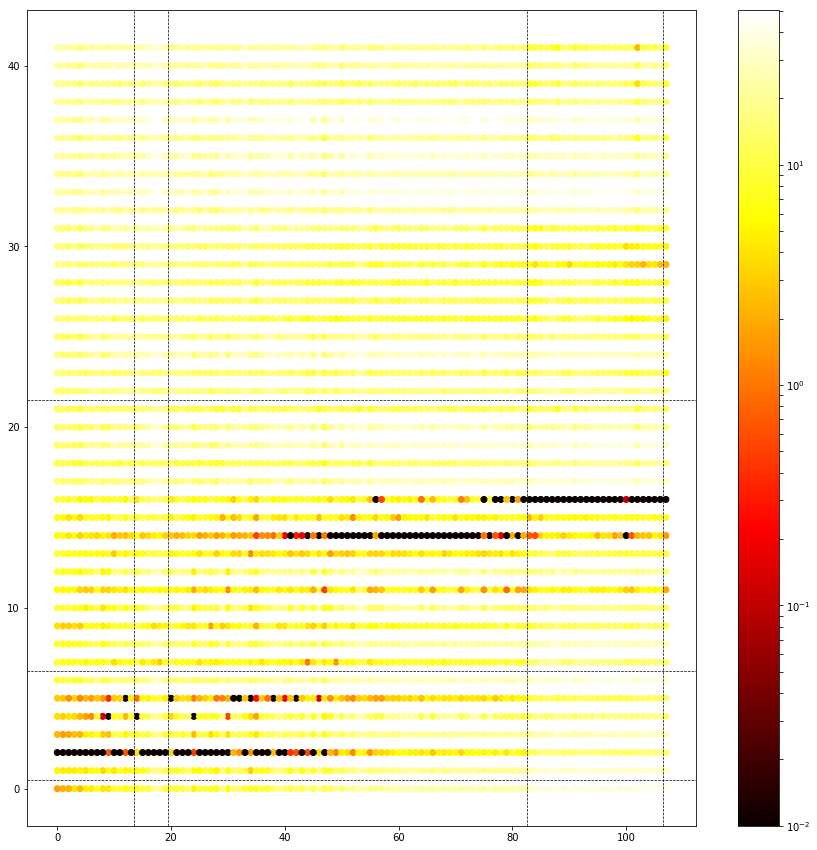

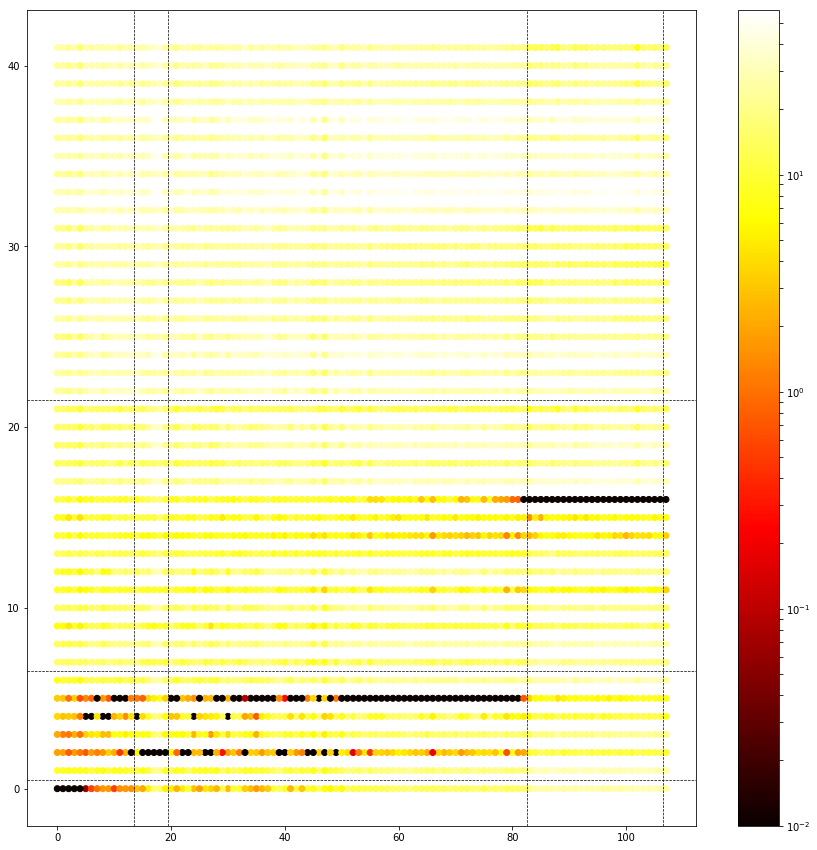

In [25]:
plotEneMap(-np.array(new_x1)+107,new_y1,np.array(new_z1)+10**-2)
plotEneMap(-np.array(new_x2)+107,new_y2,np.array(new_z2)+10**-2)

In [26]:
from matplotlib.ticker import MaxNLocator
def plotEneMap3(xyz1, xyz2, x_ticks=[0,13,19,82,107], *args, **kwargs)->None:
    '''
    x: x axis
    y: y axis
    z: z axis to color each grid
    filename: filename to save the figure
    '''
    
    
    filename=kwargs.get('filename', None)
    top_xlabel=kwargs.get('top_xlabel', 'Category')
    x_cat=kwargs.get('x_cat', [0,1,25, 88, 94, 107])
    x_cat_ticklabels=kwargs.get('x_cat_ticklabels', ['1\'','1','2', '3', '4'])
    y_cat=kwargs.get('y_cat',[0,1, 7, 22, 42, 57, 63])
    y_cat_ticklabels=kwargs.get('y_cat_ticklabels', ['-5.0','-4.0','-3.0', '-2.0', '-1.0', '0.0', '1.0'])
    
    
    x1,y1,z1=xyz1
    x2,y2,z2=xyz2
    x_cat_minor, y_cat_minor=[],[]
    
    #reverse the category
    x_cat=-np.array(x_cat)+107
    for i in range(1,len(x_cat)):
        x_cat_minor.append((x_cat[i]+x_cat[i-1])/2)
    
    for i in range(1,len(y_cat)):
        y_cat_minor.append((y_cat[i]+y_cat[i-1])/2)
    
    
    
    def reshape(x,y,z):
        X, Y,Z= list(zip(*sorted(zip(x, y, z))))
        X=np.reshape(X,(108, len(X)//108)).T
        Y=np.reshape(Y,(108, len(Y)//108)).T
        Z=np.reshape(Z,(108, len(Z)//108)).T
        return X,Y,Z
    
    X1,Y1,Z1=reshape(x1,y1,z1)
    X2,Y2,Z2=reshape(x2,y2,z2)
    data=[[X1,Y1,Z1], [X2,Y2,Z2]]
    
    #fig, axes=plt.subplots(2,sharex=True, sharey=True, gridspec_kw={'hspace': 0})
    fig, axes=plt.subplots(2,sharex=True, sharey=True)
    #label the figure
    figlabel=['A','B']
    
    
    for i, ax in enumerate(axes):
        im=ax.pcolormesh(data[i][0],data[i][1],data[i][2],norm=colors.LogNorm(), cmap='afmhot')
        ax.text(-0.1, 1.05, figlabel[i], transform=ax.transAxes,
               fontsize=16, va='top', ha='right')
        
        #ax.set_ylim(data[i][1].min()-3, data[i][1].max())
        ax.set_xticks(x_ticks)
        y_ticks=np.arange(0,42,5)
        ax.set_yticks(y_ticks)
        ax.set_ylabel('Microstate')
        
        
        xstart, xend=len(x_cat), 0
        ystart, yend=len(y_cat),0
        for j, cat in enumerate(x_cat[1:]):   #plot division vertical lines    
            if data[i][0].min() < cat < data[i][0].max():
                xstart, xend=min(j, xstart), max(xend,j)      
                ax.axvline(x=cat,color='k', linestyle='--', lw=0.7)
        
        for j,cat in enumerate(y_cat[1:]):  #plot division horizontal lines
            if data[i][1].min() < cat < data[i][1].max():
                ystart, yend=min(j, ystart), max(yend,j)    
                ax.axhline(y=cat,color='k', linestyle='--', lw=0.7)
                
        
        ax2 = ax.twinx()   # y axis on the left
        ax2.tick_params(axis="y", direction="in", length=0, width=2)
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(y_cat_minor[ystart: yend+2])
        ax2.set_yticklabels(y_cat_ticklabels[ystart:yend+2])
        ax2.set_ylabel('Ionization state')
        
        if i==0:   #x axis on the top
            ax3 = ax.twiny()
            ax3.tick_params(axis="x", direction="in", length=0, width=2)
            ax3.set_xlim(ax.get_xlim())
            ax3.set_xticks(x_cat_minor[xstart: xend+2])
            ax3.set_xticklabels(x_cat_ticklabels[xstart: xend+2])
            ax3.set_xlabel(top_xlabel)
                       

    ax.set_xlabel('Structure')
    
    cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.03])
    cbar=fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    #set the colorbar ticks and tick labels
    #cbar.set_ticks([10**-2, 10**0, 3])
    #cbar.set_ticklabels(['low', 'medium', 'high'])


    
    for a in axes:
        a.label_outer()
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if filename:
        fig.savefig(filename, dpi=300,bbox_inches='tight')
    plt.show()
 

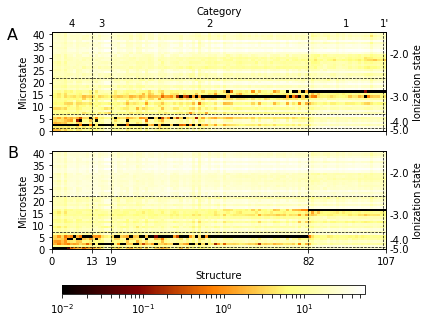

In [28]:
outputpath=r'/Users/PC/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/'

plotEneMap3([-np.array(new_x1)+107,new_y1,np.array(new_z1)+10**-2],\
            [-np.array(new_x2)+107,new_y2,np.array(new_z2)+10**-2], filename=outputpath+'StrucMsEmap_merge.tiff')


# Numbering structures by trajectroy/xray

In [29]:
x1_2,y1_2,z1_2,x_label1_2, y_label1_2=exportxyz2(df_e1)
x2_2,y2_2,z2_2, x_label2_2, y_label2_2=exportxyz2(df_f3)

{'3eh4': 0, '3s8f': 1, '3s3b': 2, '1ehk': 3, '1xme': 4, '4gp4': 5, '4gp5': 6, '3eh3': 7, '3eh5': 8, '3s3d': 9, '3s3a': 10, '3s3c': 11, 'd372ph376p_288_frame': 12, 'd372ph376p_141_frame': 13, 'd372ph376p_404_frame': 14, 'd372ph376p_55_frame': 15, 'd372ph376p_456_frame': 16, 'd372ph376p_432_frame': 17, 'd372ph376p_411_frame': 18, 'd372ph376p_243_frame': 19, 'd372ph376p_166_frame': 20, 'd372ph376p_68_frame': 21, 'd372ph376p_368_frame': 22, 'd372ph376p_255_frame': 23, 'd372ph376p_468_frame': 24, 'd372p_18_frame': 25, 'd372p_54_frame': 26, 'd372p_151_frame': 27, 'd372p_253_frame': 28, 'd372p_287_frame': 29, 'd372p_365_frame': 30, 'd372p_179_frame': 31, 'd372p_152_frame': 32, 'd372p_207_frame': 33, 'd372p_167_frame': 34, 'd372p_370_frame': 35, 'd372p_318_frame': 36, 'd372p_230_frame': 37, 'd372p_289_frame': 38, 'd372p_491_frame': 39, 'p3_435_frame': 40, 'p3_190_frame': 41, 'p3_218_frame': 42, 'p3_467_frame': 43, 'p3_297_frame': 44, 'p3_186_frame': 45, 'p3_98_frame': 46, 'p3_443_frame': 47, '

In [30]:
resetEenBase(x1_2,y1_2,z1_2)
resetEenBase(x2_2,y2_2,z2_2)

In [31]:
print(sorted(y_label1_2.items(), key=lambda kv: kv[1][0]))
#struc:struc_index
print(x_label1_2)
if x_label1_2 != x_label2_2:
    print(False)

[('-1-10-1-1-1', [0, -5]), ('-1-10-1-10', [1, -4]), ('-1-10-10-1', [2, -4]), ('-1-100-1-1', [3, -4]), ('-1-11-1-1-1', [4, -4]), ('-100-1-1-1', [5, -4]), ('0-10-1-1-1', [6, -4]), ('-1-10-100', [7, -3]), ('-1-100-10', [8, -3]), ('-1-1000-1', [9, -3]), ('-1-11-1-10', [10, -3]), ('-1-11-10-1', [11, -3]), ('-1-110-1-1', [12, -3]), ('-100-1-10', [13, -3]), ('-100-10-1', [14, -3]), ('-1000-1-1', [15, -3]), ('-101-1-1-1', [16, -3]), ('0-10-1-10', [17, -3]), ('0-10-10-1', [18, -3]), ('0-100-1-1', [19, -3]), ('0-11-1-1-1', [20, -3]), ('000-1-1-1', [21, -3]), ('-1-10000', [22, -2]), ('-1-11-100', [23, -2]), ('-1-110-10', [24, -2]), ('-1-1100-1', [25, -2]), ('-100-100', [26, -2]), ('-1000-10', [27, -2]), ('-10000-1', [28, -2]), ('-101-1-10', [29, -2]), ('-101-10-1', [30, -2]), ('-1010-1-1', [31, -2]), ('0-10-100', [32, -2]), ('0-100-10', [33, -2]), ('0-1000-1', [34, -2]), ('0-11-1-10', [35, -2]), ('0-11-10-1', [36, -2]), ('0-110-1-1', [37, -2]), ('000-1-10', [38, -2]), ('000-10-1', [39, -2]), ('00

In [33]:
new_x1_2,new_y1_2,new_z1_2= limitxy(x1_2,y1_2,z1_2, ymax=41)
new_x2_2,new_y2_2,new_z2_2= limitxy(x2_2,y2_2,z2_2,ymax=41)

/Users/caixiuhong/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


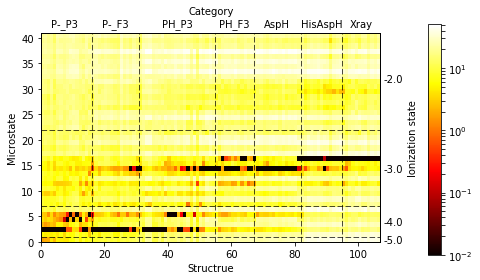

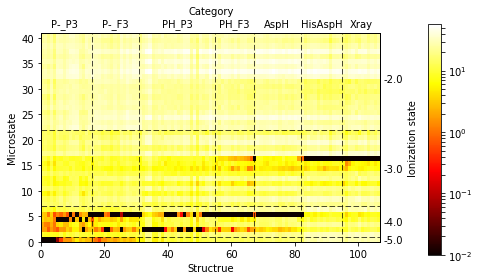

In [23]:
outputpath=r'/Users/PC/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/'

plotEneMap2(-np.array(new_x1_2)+107,new_y1_2,np.array(new_z1_2)+10**-2, filename=outputpath+'StrucbytrajMsEmap_e1.png', \
            x_cat=[0, 12,25, 40, 52, 76, 91,108],\
            x_cat_ticklabels= ['Xray','HisAspH','AspH', 'PH_F3', 'PH_P3', 'P-_F3', 'P-_P3'])
plotEneMap2(-np.array(new_x2_2)+107,new_y2_2,np.array(new_z2_2)+10**-2,filename=outputpath+'StrucbytrajMsEmap_f3.png', x_cat=[0, 12,25, 40, 52, 76, 91,108],\
            x_cat_ticklabels= ['Xray','HisAspH','AspH', 'PH_F3', 'PH_P3', 'P-_F3', 'P-_P3'])


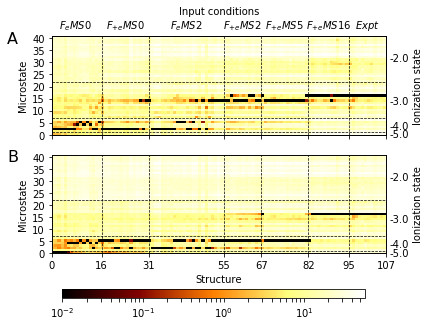

In [35]:
outputpath=r'/Users/PC/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/'

plotEneMap3([-np.array(new_x1_2)+107,new_y1_2,np.array(new_z1_2)+10**-2],\
            [-np.array(new_x2_2)+107,new_y2_2,np.array(new_z2_2)+10**-2],
            filename=outputpath+'StrucbytrajMsEmap_merge.tiff', \
            x_cat=[0, 12,25, 40, 52, 76, 91,108],\
            top_xlabel='Input conditions',
            x_ticks=[0,16,31,55,67,82,95,107],\
            x_cat_ticklabels= ['$Expt$','$F_{+e}MS16$','$F_{+e}MS5$', '$F_{+e}MS2$', '$F_eMS2$', '$F_{+e}MS0$', '$F_eMS0$'])

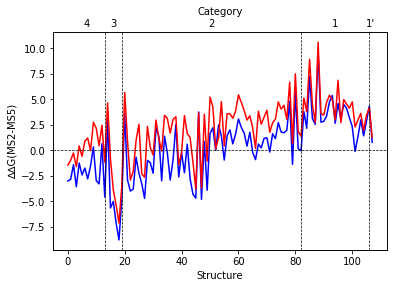

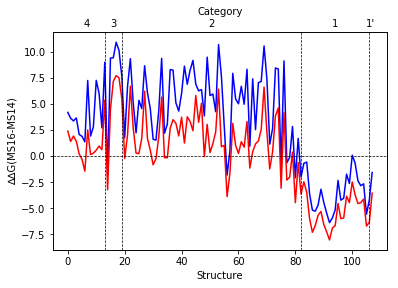

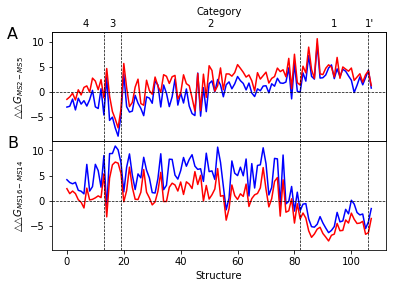

average d(ms2-ms5) at Ee at category 3: -4.720833333333334
std of d(ms2-ms5) at Ee at category 3: 3.7229321068510264
average d(ms2-ms5) at Fp at category 3: -2.672833333333332
average d(ms16-ms14) at Ee at category 1: -3.4862499999999987
std d(ms16-ms14) at Ee at category 1: 1.8212830241801137
average d(ms16-ms14) at Fp at category 1: -5.385166666666666


In [38]:
def exportEatMs(x:list, y:list, z:list, ms:int)->list:
        '''
        x: structure
        y: Microstate
        z: energy
        ms: microstate whhich want to output 
        '''
        size=max(x)
        ans=[None] * (size+1)
        for i in range(len(x)):
            if y[i]==ms:
                ans[x[i]]=z[i]
        return ans


def plotdEVSStruc(nums:list,nums2:list,y_label='∆∆G', *args, **kwargs)->None:
    '''
    nums: list of data points to plot
    x_ticks: x axis to print out
    filename: filename to save the figure
    '''
    
    filename=kwargs.get('filename', None)
    x_ticks=kwargs.get('x_ticks',None)
    top_xlabel=kwargs.get('top_xlabel', 'Category')
    x_cat=kwargs.get('x_cat', [0,1,25, 88, 94, 107])
    x_cat_ticklabels=kwargs.get('x_cat_ticklabels', ['1\'','1','2', '3', '4'])
    

    x_cat_minor=[]
    
    #reverse the category
    x_cat=-np.array(x_cat)+107
    for i in range(1,len(x_cat)):
        x_cat_minor.append((x_cat[i]+x_cat[i-1])/2)
    
    
    
    fig, ax=plt.subplots()
    ax.plot(np.arange(0,len(nums),1),nums,'b-')
    ax.plot(np.arange(0,len(nums2),1),nums2,'r-')
    if x_ticks:
        ax.set_xticks(x_ticks)
    
        
    xstart, xend=len(x_cat), 0
    for j, cat in enumerate(x_cat[1:]):   #plot division vertical lines    
        if 0 < cat < len(nums):
            xstart, xend=min(j, xstart), max(xend,j)      
            ax.axvline(x=cat,color='k', linestyle='--', lw=0.7)
    
    ax.axhline(y=0,color='k', linestyle='--', lw=0.7)    
        
    #x axis on the top
    ax3 = ax.twiny()
    ax3.tick_params(axis="x", direction="in", length=0, width=2)
    ax3.set_xlim(ax.get_xlim())
    ax3.set_xticks(x_cat_minor[xstart: xend+2])            
    ax3.set_xticklabels(x_cat_ticklabels[xstart: xend+2])
    ax3.set_xlabel(top_xlabel)
                       

    ax.set_xlabel('Structure')
    ax.set_ylabel(y_label)
    
    if filename:
        fig.savefig(filename, dpi=300,bbox_inches='tight')
    plt.show()
    
    
def plotdEVSStruc_merge(data, *args, **kwargs)->None:
    '''
    data: list of data points to plot, [[[],[]],[[],[]]]
    x_ticks: x axis to print out
    filename: filename to save the figure
    '''
    filename=kwargs.get('filename', None)
    x_ticks=kwargs.get('x_ticks',None)
    y_label=kwargs.get('y_label',['∆∆G', '∆∆G'])
    top_xlabel=kwargs.get('top_xlabel', 'Category')
    x_cat=kwargs.get('x_cat', [0,1,25, 88, 94, 107])
    x_cat_ticklabels=kwargs.get('x_cat_ticklabels', ['1\'','1','2', '3', '4'])
    

    x_cat_minor=[]
    
    #reverse the category
    x_cat=-np.array(x_cat)+107
    for i in range(1,len(x_cat)):
        x_cat_minor.append((x_cat[i]+x_cat[i-1])/2)
    
    figlabel=['A','B']
    
    fig, axes=plt.subplots(2,sharex=True, sharey=True,gridspec_kw={'hspace': 0} )
    for i, ax in enumerate(axes):
        nums,nums2=data[i]
        ax.plot(np.arange(0,len(nums),1),nums,'b-')
        ax.plot(np.arange(0,len(nums2),1),nums2,'r-')
        ax.text(-0.1, 1.05, figlabel[i], transform=ax.transAxes,
               fontsize=16, va='top', ha='right')
        
        if x_ticks:
            ax.set_xticks(x_ticks)
        ax.set_ylabel(y_label[i])
    
        
        xstart, xend=len(x_cat), 0
        for j, cat in enumerate(x_cat[1:]):   #plot division vertical lines    
            if 0 < cat < len(nums):
                xstart, xend=min(j, xstart), max(xend,j)      
                ax.axvline(x=cat,color='k', linestyle='--', lw=0.7)
    
        ax.axhline(y=0,color='k', linestyle='--', lw=0.7)    
        
        #x axis on the top
        if i==0:
            ax3 = ax.twiny()
            ax3.tick_params(axis="x", direction="in", length=0, width=2)
            ax3.set_xlim(ax.get_xlim())
            ax3.set_xticks(x_cat_minor[xstart: xend+2])            
            ax3.set_xticklabels(x_cat_ticklabels[xstart: xend+2])
            ax3.set_xlabel(top_xlabel)
                       

    ax.set_xlabel('Structure')
    
    
    if filename:
        fig.savefig(filename, dpi=300,bbox_inches='tight')
    plt.show()
    
    
def ave(nums:list)->int:
    return sum(nums)/len(nums)
    
if __name__ == "__main__":
    
    #export energy at microstate #
    Ems2=exportEatMs(new_x1, new_y1, new_z1, 2)
    Ems4=exportEatMs(new_x1, new_y1, new_z1, 5)
    Ems14=exportEatMs(new_x1, new_y1, new_z1, 14)
    Ems16=exportEatMs(new_x1, new_y1, new_z1, 16)
    
    Ems2_f3=exportEatMs(new_x2, new_y2, new_z2, 2)
    Ems4_f3=exportEatMs(new_x2, new_y2, new_z2, 5)
    Ems14_f3=exportEatMs(new_x2, new_y2, new_z2, 14)
    Ems16_f3=exportEatMs(new_x2, new_y2, new_z2, 16)
    
    #get deltaE between ms2 and ms 4, ms14 and ms16.
    delta24=np.array(Ems2)-np.array(Ems4)
    delta1614=np.array(Ems16)-np.array(Ems14)
    
    delta24_f3=np.array(Ems2_f3)-np.array(Ems4_f3)
    delta1614_f3=np.array(Ems16_f3)-np.array(Ems14_f3)
    
    outputpath=r'/Users/PC/Dropbox/cai/btype_cco/writing/submission/databackup/raw_figtab/'
    plotdEVSStruc(delta24[::-1],delta24_f3[::-1], y_label='∆∆G(MS2-MS5)',
                 filename=outputpath+'dataEMS2-MS4.tif')
    plotdEVSStruc(delta1614[::-1], delta1614_f3[::-1],y_label='∆∆G(MS16-MS14)',
                 filename=outputpath+'dataEMS16-MS14.tif')
    
    plotdEVSStruc_merge([[delta24[::-1],delta24_f3[::-1]], 
                         [delta1614[::-1], delta1614_f3[::-1]]],
                       y_label=[r'$\bigtriangleup$$\bigtriangleup$$G_{MS2-MS5}$',
                                r'$\bigtriangleup$$\bigtriangleup$$G_{MS16-MS14}$'],
                       filename=outputpath+'dataEMS2-4-14-16merge.tif')
    print('average d(ms2-ms5) at Ee at category 3:', ave(delta24[::-1][14:20]))
    print('std of d(ms2-ms5) at Ee at category 3:', np.std(delta24[::-1][14:20]))
    print('average d(ms2-ms5) at Fp at category 3:', ave(delta24_f3[::-1][14:20]))
    print('average d(ms16-ms14) at Ee at category 1:', ave(delta1614[::-1][83:107]))
    print('std d(ms16-ms14) at Ee at category 1:', np.std(delta1614[::-1][83:107]))
    print('average d(ms16-ms14) at Fp at category 1:', ave(delta1614_f3[::-1][83:107]))